### Importing the Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ace_tools_open as tools
import math

from extract_label import parse_sas_html
from pprint import pprint

In [2]:
df = pd.read_csv("data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433323 entries, 0 to 433322
Columns: 350 entries, _STATE to _DRNKDRV
dtypes: float64(345), int64(5)
memory usage: 1.1 GB


In [3]:
print(f"Number of feature: {df.shape[1]} features")
print(f"Number of row: {len(df)} rows")
df.head()

Number of feature: 350 features
Number of row: 433323 rows


,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4,_RFSEAT2,_RFSEAT3,_DRNKDRV
0,1.0,1.0,3012023,3,1,2023,1100.0,2023000001,2.023000e+09,1.0,...,0.0,1.0,0.0,1.0,2.0,2.0,2.0,1.0,1.0,9.0
1,1.0,1.0,1062023,1,6,2023,1100.0,2023000002,2.023000e+09,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,9.0
2,1.0,1.0,3082023,3,8,2023,1100.0,2023000003,2.023000e+09,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,9.0
3,1.0,1.0,3062023,3,6,2023,1100.0,2023000004,2.023000e+09,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,9.0
4,1.0,1.0,1062023,1,6,2023,1100.0,2023000005,2.023000e+09,1.0,...,7.0,1.0,47.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0


In [4]:
def missing_value_summary(df: pd.DataFrame):
    missing_count = df.isna().sum()
    missing_percentage = (df.isna().mean() * 100).round(2)
    missing_summary = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing Percentage (%)': missing_percentage
    }).sort_values(by='Missing Count', ascending=False)
    return missing_summary

In [5]:
def draw_missing_data_distribution(df: pd.DataFrame):
    plt.figure(figsize=(10,5))
    plt.hist(df["Missing Percentage (%)"], bins = 50, color='royalblue', edgecolor='black')
    plt.xlabel("Missing Percentage (%)")
    plt.ylabel("Number of Features")
    plt.title('Distribution of Missing Data Percentage Across Features')
    plt.show()

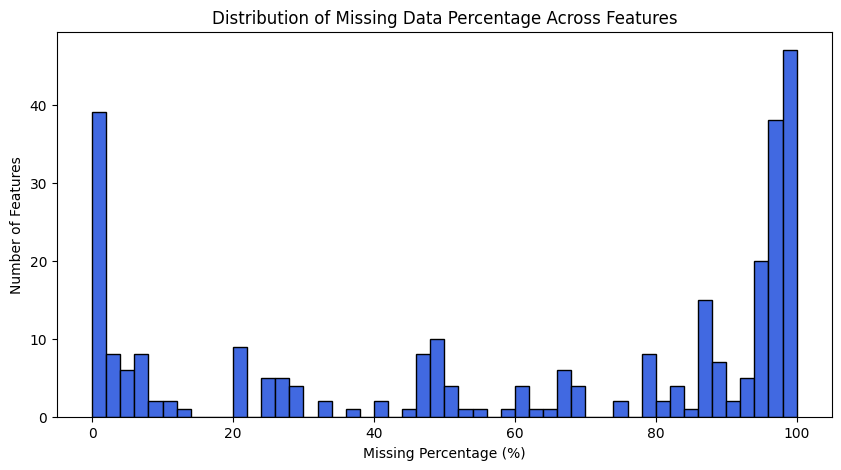

In [6]:
missing_value = missing_value_summary(df)
missing_value = missing_value[missing_value["Missing Count"] > 0]
draw_missing_data_distribution(missing_value)

#### Dropping feature which have missing value that larger than 20%

In [7]:
threshold = 20
col_to_drop = missing_value[missing_value["Missing Percentage (%)"] > threshold].index
print(f"Number of column that have more than {threshold}% missing data: {len(col_to_drop)}")
col_to_drop

Number of column that have more than 20% missing data: 221


Index(['WKDAYOUT', 'INDORTAN', 'NUMBURN3', 'SUNPRTCT', 'WKENDOUT', 'COLGHOUS',
       'LASTSIG4', 'LNDSXBRT', 'CSRVCTL2', 'VCLNTES2',
       ...
       'EXRACT12', 'CSTATE1', 'HHADULT', 'CELLSEX2', 'LANDLINE', 'PVTRESD3',
       'CADULT1', 'CTELNUM1', 'SAFETIME', 'CELLFON5'],
      dtype='object', length=221)

In [8]:
df = df.drop(columns=col_to_drop)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433323 entries, 0 to 433322
Columns: 129 entries, _STATE to _DRNKDRV
dtypes: float64(124), int64(5)
memory usage: 426.5 MB


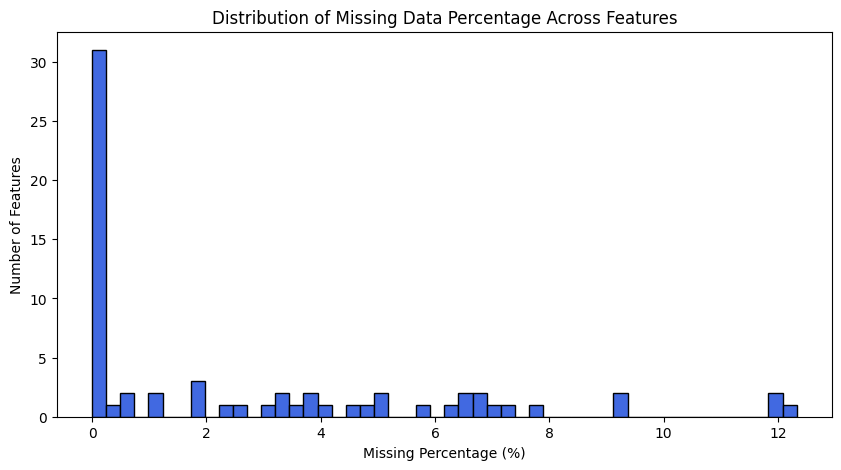

In [9]:
missing_value = missing_value_summary(df)
missing_value = missing_value[missing_value["Missing Count"] > 0]
draw_missing_data_distribution(missing_value)

#### Decode the data

In [10]:
sas_variable, value_labels = parse_sas_html("Original Data/USCODE23_LLCP_091024.HTML")


In [11]:
missing_value_summary(df)

,Missing Count,Missing Percentage (%)
CHOLMED3,53440,12.33
TOLDHI3,51812,11.96
_RFCHOL3,51811,11.96
_BMI5,40535,9.35
_BMI5CAT,40535,9.35
...,...,...
_RFBING6,0,0.00
_RFDRHV8,0,0.00
_RFSEAT2,0,0.00
_RFSEAT3,0,0.00


In [12]:
df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,SEXVAR,...,_CURECI2,DRNKANY6,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_AIDTST4,_RFSEAT2,_RFSEAT3,_DRNKDRV
0,1.0,1.0,3012023,3,1,2023,1100.0,2023000001,2.023000e+09,2.0,...,1.0,2.0,0.0,1.0,0.0,1.0,2.0,1.0,1.0,9.0
1,1.0,1.0,1062023,1,6,2023,1100.0,2023000002,2.023000e+09,2.0,...,1.0,2.0,0.0,1.0,0.0,1.0,2.0,1.0,1.0,9.0
2,1.0,1.0,3082023,3,8,2023,1100.0,2023000003,2.023000e+09,2.0,...,1.0,2.0,0.0,1.0,0.0,1.0,2.0,1.0,1.0,9.0
3,1.0,1.0,3062023,3,6,2023,1100.0,2023000004,2.023000e+09,2.0,...,1.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,9.0
4,1.0,1.0,1062023,1,6,2023,1100.0,2023000005,2.023000e+09,2.0,...,1.0,1.0,7.0,1.0,47.0,1.0,2.0,1.0,1.0,2.0


In [13]:
cols = df.columns
for col in cols:
    print(f"{col}: \t {sas_variable[col]}")

_STATE: 	 State FIPS Code
FMONTH: 	 File Month
IDATE: 	 Interview Date
IMONTH: 	 Interview Month
IDAY: 	 Interview Day
IYEAR: 	 Interview Year
DISPCODE: 	 Final Disposition
SEQNO: 	 Annual Sequence Number
_PSU: 	 Primary Sampling Unit
SEXVAR: 	 Sex of Respondent
GENHLTH: 	 General Health
PHYSHLTH: 	 Number of Days Physical Health Not Good
MENTHLTH: 	 Number of Days Mental Health Not Good
PRIMINS1: 	 What is Current Primary Source of Health Insurance?
PERSDOC3: 	 Have Personal Health Care Provider?
MEDCOST1: 	 Could Not Afford To See Doctor
CHECKUP1: 	 Length of time since last routine checkup
EXERANY2: 	 Exercise in Past 30 Days
STRENGTH: 	 How many times did you do physical activities or exercises to STRENGTHEN your muscles?
BPHIGH6: 	 Ever Told Blood Pressure High
CHOLCHK3: 	 How Long since Cholesterol Checked
TOLDHI3: 	 Ever Told Cholesterol Is High
CHOLMED3: 	 Currently taking medicine for high cholesterol
CVDINFR4: 	 Ever Diagnosed with Heart Attack
CVDCRHD4: 	 Ever Diagnosed with

### Scan and Identify Features Directly Related to Heart Disease
Since we are predicting heart disease, keep features that are risk factors or direct indicator of cardiovascular health. Relavant features might includes
- General:
    - **`SEXVAR`**: Sex of Respondent
    - **`_AGE80`**: Imputed Age value collapsed above 80
    - **`_AGEG5YR`**: IReported age in five-year age categories calculated variable
- Existing Heart Conditions:
    - **`CVDINFR4`**: Ever Diagnosed with Heart Attack
    - **`CVDCRHD4`**: Ever Diagnosed with Angina or Coronary Heart Disease
    - **`CVDSTRK3`**: Ever Diagnosed with a Stroke
- Cholesterol and Blood Pressure:
    - **`BPHIGH6`**: Ever Told Blood Pressure High
    - **`CHOLCHK3`**: How Long Since Cholesterol Checked
    - **`TOLDHI3`**: Ever Told Cholesterol Is High
    - **`CHOLMED3`**: Currently Taking Medicine for High Cholesterol
- Diabetes & Related Conditions:
    - **`DIABETE4`**: (Ever Told) You Had Diabetes
    - **`CHCKDNY2`**: Ever Told You Have Kidney Disease
    - **`HAVARTH4`**: Told Had Arthritis (Linked to inflammation)
- Health Status & Lifestyle:
    - **`GENHLTH`**: General Health
    - **`PHYSHLTH`**: Number of Days Physical Health Not Good
    - **`MENTHLTH`**: Number of Days Mental Health Not Good
    - **`EXERANY2`**: Exercise in Past 30 Days
    - **`STRENGTH`**: Physical Strengthening Exercise
- Smoking & Alcohol Consumption:
    - **`SMOKE100`**: Smoked at Least 100 Cigarettes
    - **`USENOW3`**: Use of Smokeless Tobacco Products
    - **`ECIGNOW2`**: Do You Now Use E-Cigarettes?
    - **`ALCDAY4`**: Alcohol Consumption in Past 30 Days
- Weight, BMI & Obesity Indicators:
    - **`WEIGHT2`**: Reported Weight in Pounds
    - **`HEIGHT3`**: Reported Height in Feet and Inches
    - **`_BMI5`**: Computed Body Mass Index

In [14]:
# Relevant features for heart disease prediction
selected_features = [
    # General
    "SEXVAR", "_AGE80", "_AGEG5YR", 

    # Heart Disease Indicators
    "CVDINFR4", "CVDCRHD4", "CVDSTRK3",
    
    # Cholesterol and Blood Pressure
    "BPHIGH6", "CHOLCHK3", "TOLDHI3", "CHOLMED3",
    
    # Diabetes & Related Conditions
    "DIABETE4", "CHCKDNY2", "HAVARTH4",
    
    # General Health and Lifestyle
    "GENHLTH", "PHYSHLTH", "MENTHLTH", "EXERANY2", "STRENGTH",
    
    # Smoking & Alcohol Consumption
    "SMOKE100", "USENOW3", "ECIGNOW2", "ALCDAY4",
    
    # Weight, BMI & Obesity Indicators
    "WEIGHT2", "HEIGHT3", "_BMI5"
]

df_filtered = df[selected_features]
df_filtered.head()

,SEXVAR,_AGE80,_AGEG5YR,CVDINFR4,CVDCRHD4,CVDSTRK3,BPHIGH6,CHOLCHK3,TOLDHI3,CHOLMED3,...,MENTHLTH,EXERANY2,STRENGTH,SMOKE100,USENOW3,ECIGNOW2,ALCDAY4,WEIGHT2,HEIGHT3,_BMI5
0,2.0,80.0,13.0,2.0,2.0,2.0,1.0,3.0,2.0,2.0,...,88.0,2.0,888.0,2.0,3.0,1.0,888.0,172.0,503.0,3047.0
1,2.0,80.0,13.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,...,88.0,1.0,888.0,2.0,3.0,1.0,888.0,132.0,409.0,2856.0
2,2.0,80.0,13.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,...,2.0,1.0,205.0,1.0,3.0,1.0,888.0,130.0,504.0,2231.0
3,2.0,78.0,12.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,...,88.0,1.0,888.0,2.0,3.0,1.0,888.0,170.0,506.0,2744.0
4,2.0,76.0,12.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,...,88.0,1.0,888.0,2.0,2.0,1.0,202.0,170.0,508.0,2585.0


In [15]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433323 entries, 0 to 433322
Data columns (total 25 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   SEXVAR    433323 non-null  float64
 1   _AGE80    433323 non-null  float64
 2   _AGEG5YR  433323 non-null  float64
 3   CVDINFR4  433320 non-null  float64
 4   CVDCRHD4  433320 non-null  float64
 5   CVDSTRK3  433319 non-null  float64
 6   BPHIGH6   433320 non-null  float64
 7   CHOLCHK3  433320 non-null  float64
 8   TOLDHI3   381511 non-null  float64
 9   CHOLMED3  379883 non-null  float64
 10  DIABETE4  433318 non-null  float64
 11  CHCKDNY2  433320 non-null  float64
 12  HAVARTH4  433319 non-null  float64
 13  GENHLTH   433319 non-null  float64
 14  PHYSHLTH  433320 non-null  float64
 15  MENTHLTH  433320 non-null  float64
 16  EXERANY2  433321 non-null  float64
 17  STRENGTH  433319 non-null  float64
 18  SMOKE100  413649 non-null  float64
 19  USENOW3   412886 non-null  float64
 20  ECIG

### Extractting value label for selected features

In [16]:
value_labels_filtered = {key: value_labels[key] for key in selected_features}
pprint(value_labels_filtered)

{'ALCDAY4': {'101 - 199': 'Days per weekNotes: 1_ _ = Days per week',
             '201 - 299': 'Days in past 30 daysNotes: 2_ _ = Days in past 30',
             '777': 'Don’t know/Not sure—Go to Section 13.01 FLUSHOT7',
             '888': 'No drinks in past 30 days—Go to Section 13.01 FLUSHOT7',
             '999': 'Refused—Go to Section 13.01 FLUSHOT7',
             'BLANK': 'Not asked or Missing'},
 'BPHIGH6': {'1': 'Yes',
             '2': 'Yes, but female told only during pregnancy—Go to Section '
                  '06.01 CHOLCHK3',
             '3': 'No—Go to Section 06.01 CHOLCHK3',
             '4': 'Told borderline high or pre-hypertensive or elevated blood '
                  'pressure—Go to Section 06.01 CHOLCHK3',
             '7': 'Don´t know/Not Sure—Go to Section 06.01 CHOLCHK3',
             '9': 'Refused—Go to Section 06.01 CHOLCHK3',
             'BLANK': 'Not asked or Missing'},
 'CHCKDNY2': {'1': 'Yes',
              '2': 'No',
              '7': 'Don’t know / Not 

In [17]:
# Category features list
category_features = ['SEXVAR', '_AGEG5YR','BPHIGH6', 'CHCKDNY2', 'CHOLCHK3', 'CHOLMED3', 'CVDCRHD4', 'CVDINFR4', 'CVDSTRK3',
                     'DIABETE4', 'ECIGNOW2', 'EXERANY2', 'GENHLTH', 'HAVARTH4', 'SMOKE100', 'TOLDHI3', 'USENOW3']
binary_features = ['SEXVAR', 'CHOLMED3', 'CVDCRHD4', 'CVDINFR4', 'CVDSTRK3', 'EXERANY2', 'HAVARTH4', 'SMOKE100', 'TOLDHI3']
nominal_features = ['BPHIGH6', 'CHCKDNY2', 'DIABETE4']
ordinal_features = ['_AGEG5YR', 'CHOLCHK3', 'ECIGNOW2', 'GENHLTH', 'USENOW3']

# Numerical Features list
numeric_featutes = [feature for feature in selected_features if feature not in category_features]

print(f"Number of sellected features: {len(selected_features)} features.")
print(f"""Number of categorical features: {len(category_features)} features with 
      {"\t"*5}{len(binary_features)} binary features, 
      {"\t"*5}{len(nominal_features)} nominal features, 
      {"\t"*5}{len(ordinal_features)} ordinal features.""")
print(f"Number of numerical features: {len(numeric_featutes)} features.")

Number of sellected features: 25 features.
Number of categorical features: 17 features with 
      					9 binary features, 
      					3 nominal features, 
      					5 ordinal features.
Number of numerical features: 8 features.


In [18]:
def pretty_print(feature_list):
    pprint({key: sas_variable[key] for key in feature_list})
    print()
    pprint({key: value_labels[key] for key in feature_list})

In [19]:
pretty_print(category_features)

{'BPHIGH6': 'Ever Told Blood Pressure High',
 'CHCKDNY2': 'Ever told you have kidney disease?',
 'CHOLCHK3': 'How Long since Cholesterol Checked',
 'CHOLMED3': 'Currently taking medicine for high cholesterol',
 'CVDCRHD4': 'Ever Diagnosed with Angina or Coronary Heart Disease',
 'CVDINFR4': 'Ever Diagnosed with Heart Attack',
 'CVDSTRK3': 'Ever Diagnosed with a Stroke',
 'DIABETE4': '(Ever told) you had diabetes',
 'ECIGNOW2': 'Do you now use e-cigarettes, or vaping products every day, some '
             'days, or not at all?',
 'EXERANY2': 'Exercise in Past 30 Days',
 'GENHLTH': 'General Health',
 'HAVARTH4': 'Told Had Arthritis',
 'SEXVAR': 'Sex of Respondent',
 'SMOKE100': 'Smoked at Least 100 Cigarettes',
 'TOLDHI3': 'Ever Told Cholesterol Is High',
 'USENOW3': 'Use of Smokeless Tobacco Products',
 '_AGEG5YR': 'Reported age in five-year age categories calculated variable'}

{'BPHIGH6': {'1': 'Yes',
             '2': 'Yes, but female told only during pregnancy—Go to Section '
     

In [20]:
pretty_print(numeric_featutes)

{'ALCDAY4': 'Days in past 30 had alcoholic beverage',
 'HEIGHT3': 'Reported Height in Feet and Inches',
 'MENTHLTH': 'Number of Days Mental Health Not Good',
 'PHYSHLTH': 'Number of Days Physical Health Not Good',
 'STRENGTH': 'How many times did you do physical activities or exercises to '
             'STRENGTHEN your muscles?',
 'WEIGHT2': 'Reported Weight in Pounds',
 '_AGE80': 'Imputed Age value collapsed above 80',
 '_BMI5': 'Computed body mass index'}

{'ALCDAY4': {'101 - 199': 'Days per weekNotes: 1_ _ = Days per week',
             '201 - 299': 'Days in past 30 daysNotes: 2_ _ = Days in past 30',
             '777': 'Don’t know/Not sure—Go to Section 13.01 FLUSHOT7',
             '888': 'No drinks in past 30 days—Go to Section 13.01 FLUSHOT7',
             '999': 'Refused—Go to Section 13.01 FLUSHOT7',
             'BLANK': 'Not asked or Missing'},
 'HEIGHT3': {'200 - 711': 'Height (ft/inches)Notes: 0 _ / _ _ = feet / inches',
             '7777': 'Don’t know/Not sure',
      

In [21]:
# Convert dictionary to DataFrame for better visualization
df_value_labels_category = pd.DataFrame.from_dict({key: value_labels[key] for key in category_features}, orient='index')

# Display the dictionary in a structured format
tools.display_dataframe_to_user(name="Value Labels Dictionary of Categorical Features", dataframe=df_value_labels_category)

Value Labels Dictionary of Categorical Features


In [22]:
# Convert dictionary to DataFrame for better visualization
df_value_labels_numeric = pd.DataFrame.from_dict({key: value_labels[key] for key in numeric_featutes}, orient='index')

# Display the dictionary in a structured format
tools.display_dataframe_to_user(name="Value Labels Dictionary of Numerical Features", dataframe=df_value_labels_numeric)

Value Labels Dictionary of Numerical Features


### Missing value and outlier

In [23]:
missing_value_summary(df_filtered)

,Missing Count,Missing Percentage (%)
CHOLMED3,53440,12.33
TOLDHI3,51812,11.96
_BMI5,40535,9.35
ALCDAY4,25444,5.87
ECIGNOW2,21467,4.95
USENOW3,20437,4.72
SMOKE100,19674,4.54
HEIGHT3,11649,2.69
WEIGHT2,10611,2.45
DIABETE4,5,0.00


In [24]:
invalid_code = {7, 9}
for col in category_features:
    if col != '_AGEG5YR':
        df_filtered[col] = df_filtered[col].replace(invalid_code, np.nan)
        df_filtered[col] = df_filtered[col].fillna(df_filtered[col].mode()[0])
df_filtered

C:\Users\minhh\AppData\Local\Temp\ipykernel_5984\3048558544.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = df_filtered[col].replace(invalid_code, np.nan)
C:\Users\minhh\AppData\Local\Temp\ipykernel_5984\3048558544.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = df_filtered[col].fillna(df_filtered[col].mode()[0])


,SEXVAR,_AGE80,_AGEG5YR,CVDINFR4,CVDCRHD4,CVDSTRK3,BPHIGH6,CHOLCHK3,TOLDHI3,CHOLMED3,...,MENTHLTH,EXERANY2,STRENGTH,SMOKE100,USENOW3,ECIGNOW2,ALCDAY4,WEIGHT2,HEIGHT3,_BMI5
0,2.0,80.0,13.0,2.0,2.0,2.0,1.0,3.0,2.0,2.0,...,88.0,2.0,888.0,2.0,3.0,1.0,888.0,172.0,503.0,3047.0
1,2.0,80.0,13.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,...,88.0,1.0,888.0,2.0,3.0,1.0,888.0,132.0,409.0,2856.0
2,2.0,80.0,13.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,...,2.0,1.0,205.0,1.0,3.0,1.0,888.0,130.0,504.0,2231.0
3,2.0,78.0,12.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,...,88.0,1.0,888.0,2.0,3.0,1.0,888.0,170.0,506.0,2744.0
4,2.0,76.0,12.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,...,88.0,1.0,888.0,2.0,2.0,1.0,202.0,170.0,508.0,2585.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433318,1.0,65.0,10.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,...,30.0,1.0,888.0,2.0,3.0,1.0,105.0,240.0,604.0,2921.0
433319,2.0,30.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,...,88.0,2.0,888.0,2.0,3.0,1.0,888.0,150.0,505.0,2496.0
433320,2.0,51.0,7.0,2.0,2.0,2.0,3.0,2.0,1.0,2.0,...,88.0,1.0,104.0,2.0,3.0,1.0,201.0,213.0,506.0,3438.0
433321,2.0,65.0,10.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,...,88.0,1.0,888.0,2.0,3.0,1.0,888.0,139.0,504.0,2386.0


In [25]:
def plot(df: pd.DataFrame, col: str):
    # Create a figure with 2 subplots: 1 row, 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Boxplot
    df.boxplot(column=col, ax=axes[0])
    axes[0].set_title(f"Box Plot of {col}")

    # Histogram
    df.hist(column=col, ax=axes[1], bins=30, color='royalblue', edgecolor='black')
    axes[1].set_title(f"Histogram of {col}")

    # Show combined plots
    plt.tight_layout()
    plt.show()

ALCDAY4 convert in to day per past 30 days

In [26]:
def convert_day_in_months(value):
    if value is not np.nan:
        if 100 < value < 200:
            return math.floor((value % 100) * (30/7))
        elif 200 < value < 300:
            return value % 200
        elif value == 888:
            return 0
        else:
            return np.nan
    return np.nan

In [27]:
df_filtered["ALCDAY4"] = df_filtered["ALCDAY4"].apply(convert_day_in_months)
df_filtered["ALCDAY4"] = df_filtered["ALCDAY4"].fillna(np.round(df_filtered["ALCDAY4"].mean()))
df_filtered["ALCDAY4"].describe()

C:\Users\minhh\AppData\Local\Temp\ipykernel_5984\529066701.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["ALCDAY4"] = df_filtered["ALCDAY4"].apply(convert_day_in_months)
C:\Users\minhh\AppData\Local\Temp\ipykernel_5984\529066701.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["ALCDAY4"] = df_filtered["ALCDAY4"].fillna(np.round(df_filtered["ALCDAY4"].mean()))


count    433323.000000
mean          4.859825
std           7.794252
min           0.000000
25%           0.000000
50%           1.000000
75%           5.000000
max          30.000000
Name: ALCDAY4, dtype: float64

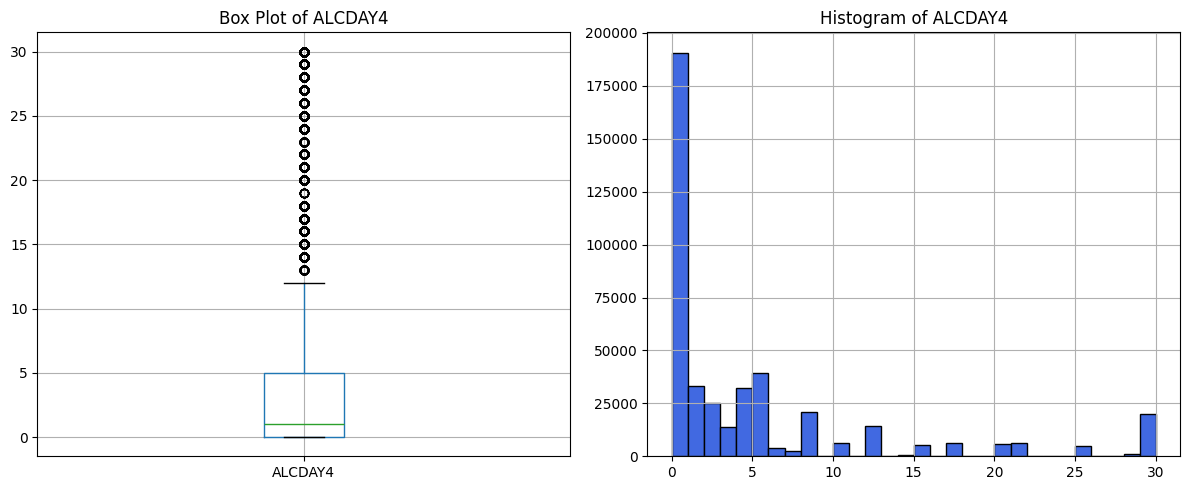

In [28]:
plot(df_filtered, "ALCDAY4")

HEIGHT3

In [29]:
def convert_height3(value):
    if value is not np.nan:
        if 199 < value < 712:
            return value // 100 + (value % 100)/12
        elif 9060 < value < 9999:
            return ((value % 9000)/100) * 3.28084       # convert to meters then convert back to feets
        else:
            return np.nan
    return np.nan
df_filtered["HEIGHT3"] = df_filtered["HEIGHT3"].apply(convert_height3)
df_filtered["HEIGHT3"] = df_filtered["HEIGHT3"].fillna(df_filtered["HEIGHT3"].mean())
df_filtered["HEIGHT3"].describe()

C:\Users\minhh\AppData\Local\Temp\ipykernel_5984\753322308.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["HEIGHT3"] = df_filtered["HEIGHT3"].apply(convert_height3)
C:\Users\minhh\AppData\Local\Temp\ipykernel_5984\753322308.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["HEIGHT3"] = df_filtered["HEIGHT3"].fillna(df_filtered["HEIGHT3"].mean())


count    433323.000000
mean          5.585515
std           0.346606
min           2.000000
25%           5.333333
50%           5.583333
75%           5.833333
max          28.313649
Name: HEIGHT3, dtype: float64

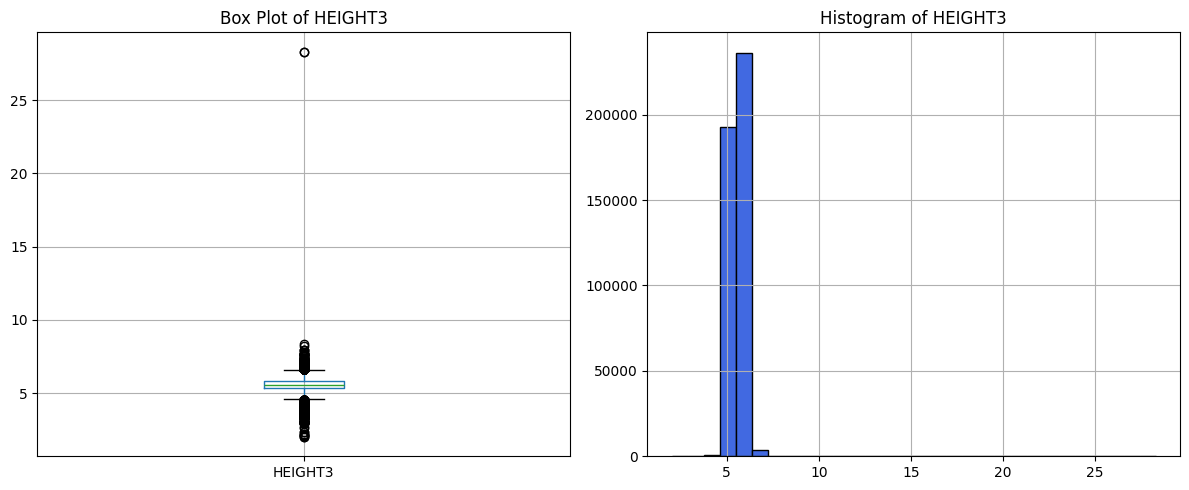

In [30]:
plot(df_filtered, "HEIGHT3")

MENTHLTH

In [31]:
def convert_day(value):
    if value is not np.nan:
        if 1 <= value <= 30:
            return value
        else:
            return np.nan
    return np.nan
df_filtered["MENTHLTH"] = df_filtered["MENTHLTH"].apply(convert_day)
df_filtered["MENTHLTH"] = df_filtered["MENTHLTH"].fillna(df_filtered["MENTHLTH"].mode()[0])
df_filtered["MENTHLTH"].describe()

C:\Users\minhh\AppData\Local\Temp\ipykernel_5984\2868777363.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["MENTHLTH"] = df_filtered["MENTHLTH"].apply(convert_day)
C:\Users\minhh\AppData\Local\Temp\ipykernel_5984\2868777363.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["MENTHLTH"] = df_filtered["MENTHLTH"].fillna(df_filtered["MENTHLTH"].mode()[0])


count    433323.000000
mean         22.632701
std          11.181164
min           1.000000
25%          10.000000
50%          30.000000
75%          30.000000
max          30.000000
Name: MENTHLTH, dtype: float64

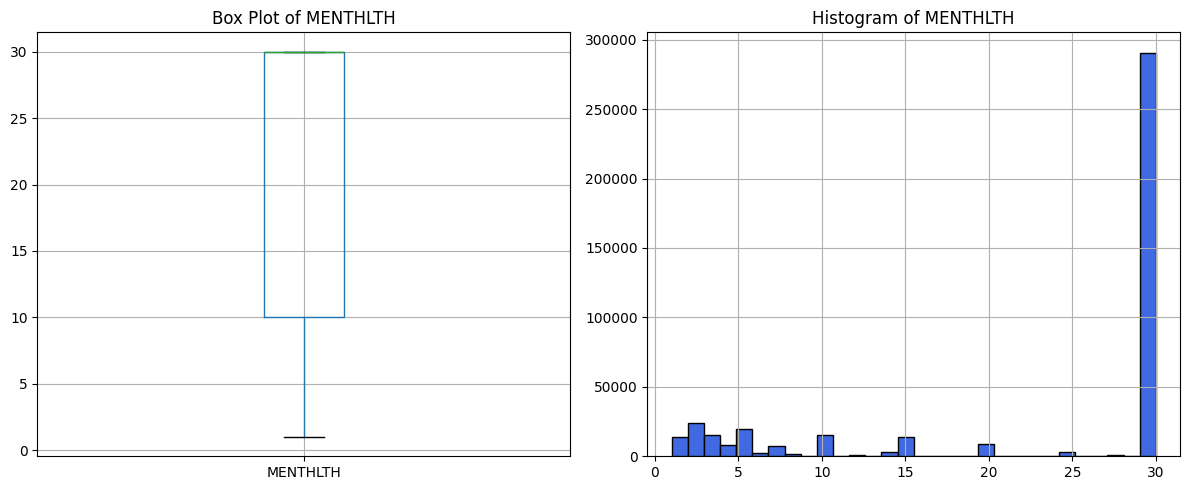

In [32]:
plot(df_filtered, "MENTHLTH")

PHYSHLTH

In [33]:
df_filtered["PHYSHLTH"] = df_filtered["PHYSHLTH"].apply(convert_day)
df_filtered["PHYSHLTH"] = df_filtered["PHYSHLTH"].fillna(df_filtered["PHYSHLTH"].mode()[0])
df_filtered["PHYSHLTH"].describe()

C:\Users\minhh\AppData\Local\Temp\ipykernel_5984\14972374.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["PHYSHLTH"] = df_filtered["PHYSHLTH"].apply(convert_day)
C:\Users\minhh\AppData\Local\Temp\ipykernel_5984\14972374.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["PHYSHLTH"] = df_filtered["PHYSHLTH"].fillna(df_filtered["PHYSHLTH"].mode()[0])


count    433323.000000
mean         22.880311
std          11.284828
min           1.000000
25%          14.000000
50%          30.000000
75%          30.000000
max          30.000000
Name: PHYSHLTH, dtype: float64

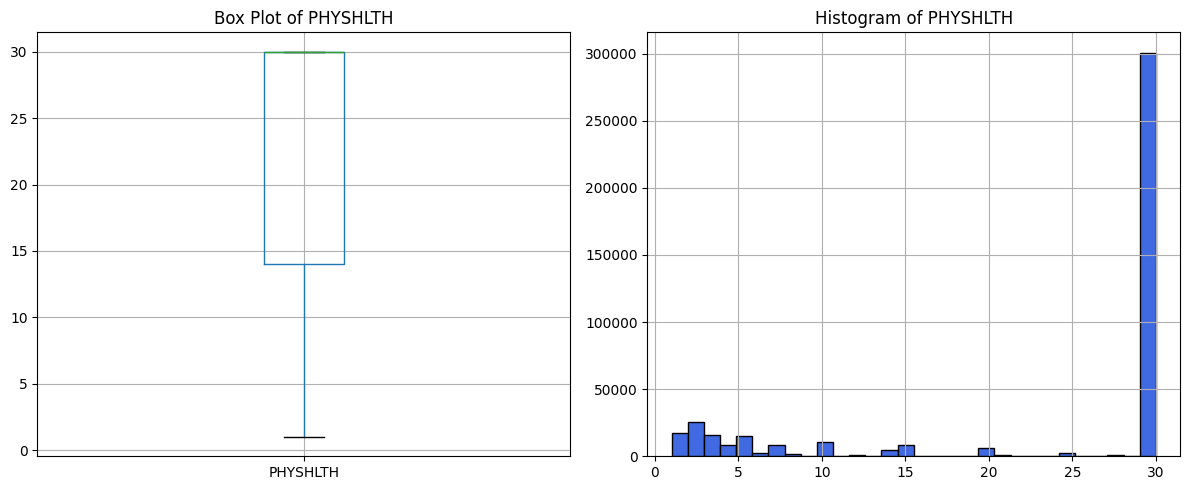

In [34]:
plot(df_filtered, "PHYSHLTH")

STRENGTH

In [35]:
df_filtered["STRENGTH"] = df_filtered["STRENGTH"].apply(convert_day_in_months)
df_filtered["STRENGTH"] = df_filtered["STRENGTH"].fillna(np.round(df_filtered["STRENGTH"].mean()))
df_filtered["STRENGTH"].describe()

C:\Users\minhh\AppData\Local\Temp\ipykernel_5984\2766202249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["STRENGTH"] = df_filtered["STRENGTH"].apply(convert_day_in_months)
C:\Users\minhh\AppData\Local\Temp\ipykernel_5984\2766202249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["STRENGTH"] = df_filtered["STRENGTH"].fillna(np.round(df_filtered["STRENGTH"].mean()))


count    433323.000000
mean          8.026052
std          14.931028
min           0.000000
25%           0.000000
50%           4.000000
75%          12.000000
max         424.000000
Name: STRENGTH, dtype: float64

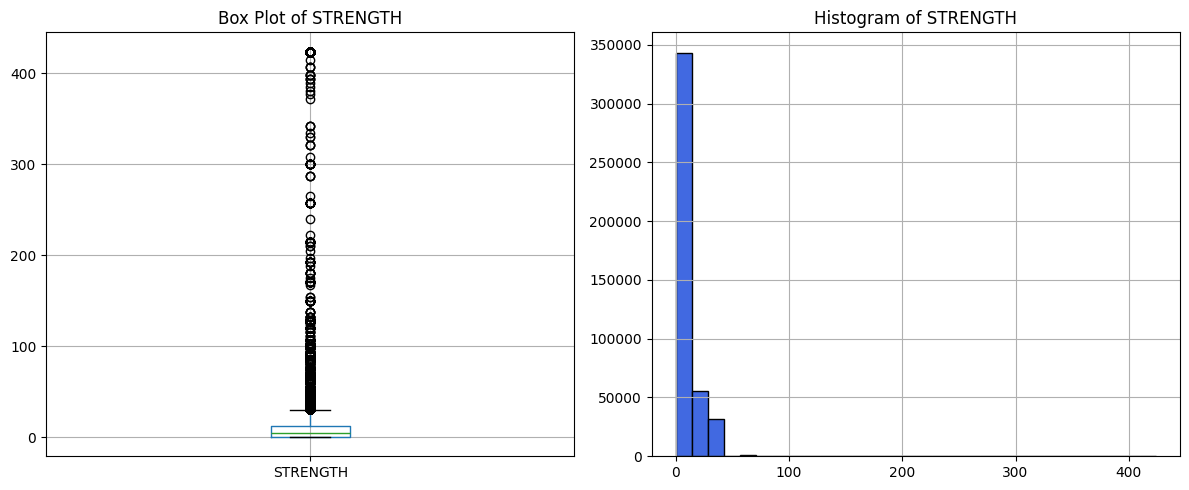

In [36]:
plot(df_filtered, "STRENGTH")

WEIGHT2

In [37]:
def convert_weight(value):
    if value is not np.nan:
        if 50 <= value <= 776:
            return value
        elif 9023 <= value <= 9352:
            return (value % 9000) * 2.20462
        else:
            return np.nan
    return np.nan

In [38]:
df_filtered["WEIGHT2"] = df_filtered["WEIGHT2"].apply(convert_weight)
df_filtered["WEIGHT2"] = df_filtered["WEIGHT2"].fillna(df_filtered["WEIGHT2"].mean())
df_filtered["WEIGHT2"].describe()

C:\Users\minhh\AppData\Local\Temp\ipykernel_5984\711453235.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["WEIGHT2"] = df_filtered["WEIGHT2"].apply(convert_weight)
C:\Users\minhh\AppData\Local\Temp\ipykernel_5984\711453235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["WEIGHT2"] = df_filtered["WEIGHT2"].fillna(df_filtered["WEIGHT2"].mean())


count    433323.000000
mean        182.745727
std          45.214995
min          50.000000
25%         150.000000
50%         180.000000
75%         203.000000
max         776.000000
Name: WEIGHT2, dtype: float64

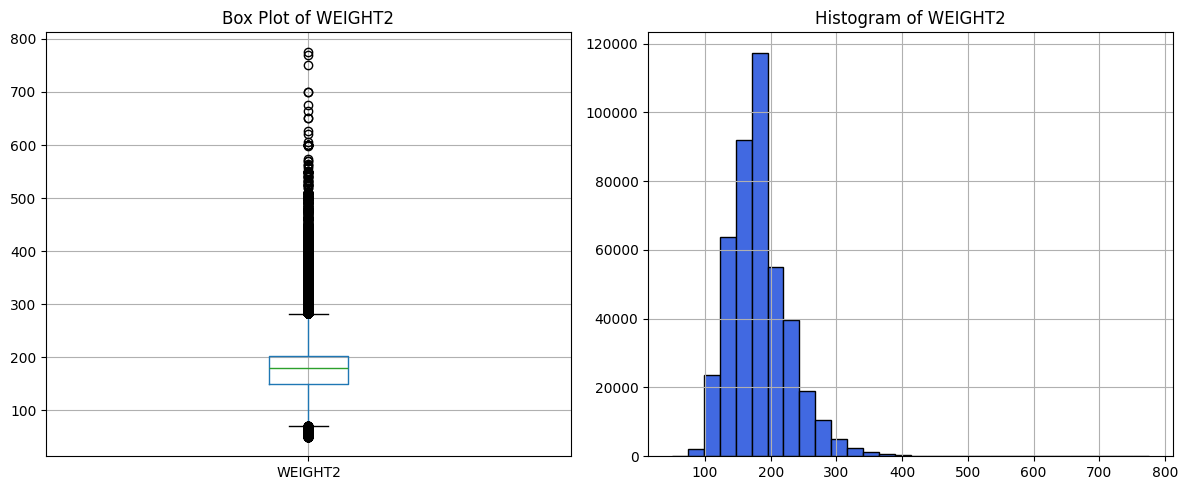

In [39]:
plot(df_filtered, "WEIGHT2")

_BMI5

In [40]:
def convert_BMI(value):
    if value is not np.nan:
        if 1 <= value <= 9999:
            return value / 100
        else:
            return np.nan
    return np.nan

In [41]:
df_filtered["_BMI5"] = df_filtered["_BMI5"].apply(convert_BMI)
df_filtered["_BMI5"] = df_filtered["_BMI5"].fillna(df_filtered["_BMI5"].mean())
df_filtered["_BMI5"].describe()

C:\Users\minhh\AppData\Local\Temp\ipykernel_5984\736245865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["_BMI5"] = df_filtered["_BMI5"].apply(convert_BMI)
C:\Users\minhh\AppData\Local\Temp\ipykernel_5984\736245865.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["_BMI5"] = df_filtered["_BMI5"].fillna(df_filtered["_BMI5"].mean())


count    433323.000000
mean         28.479288
std           6.228480
min          12.020000
25%          24.390000
50%          28.170000
75%          31.090000
max          99.840000
Name: _BMI5, dtype: float64

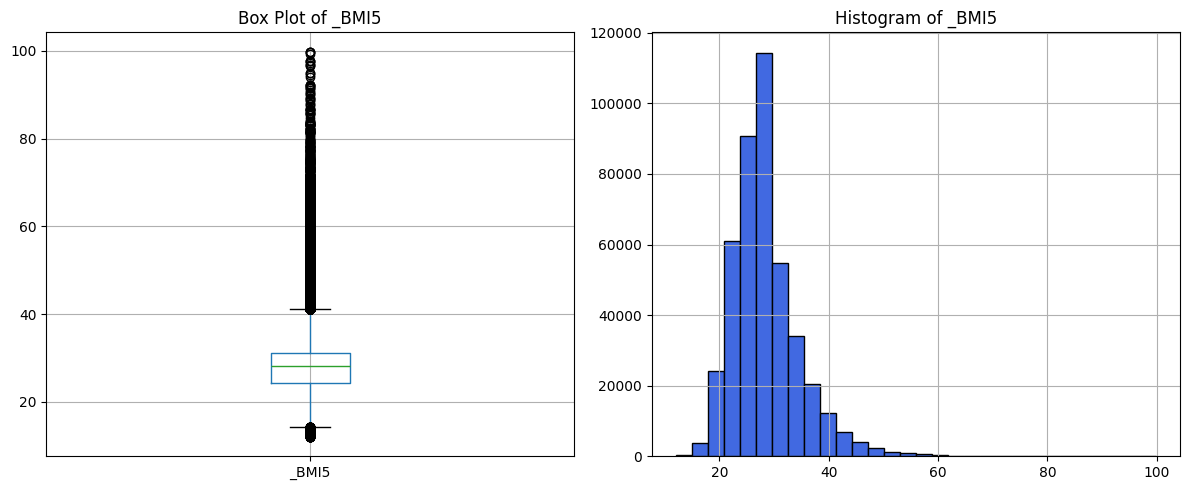

In [42]:
plot(df_filtered, "_BMI5")

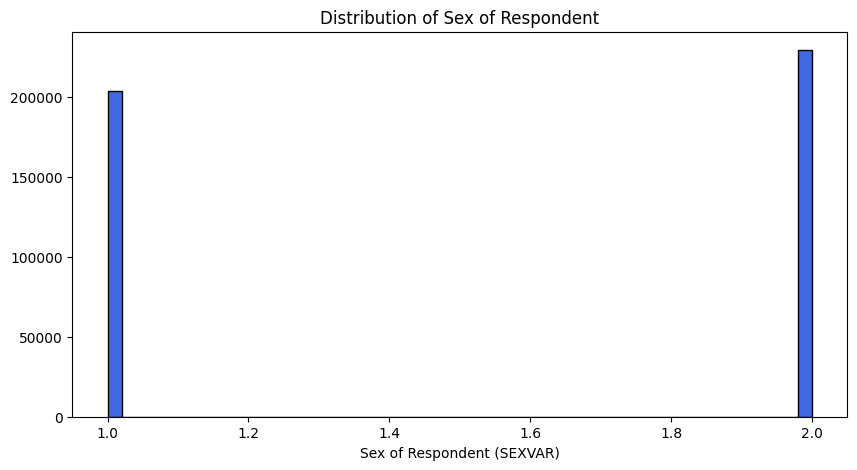

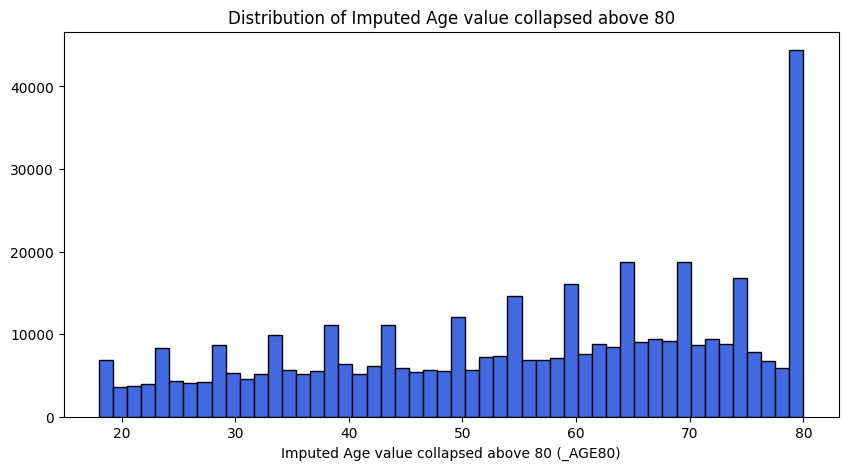

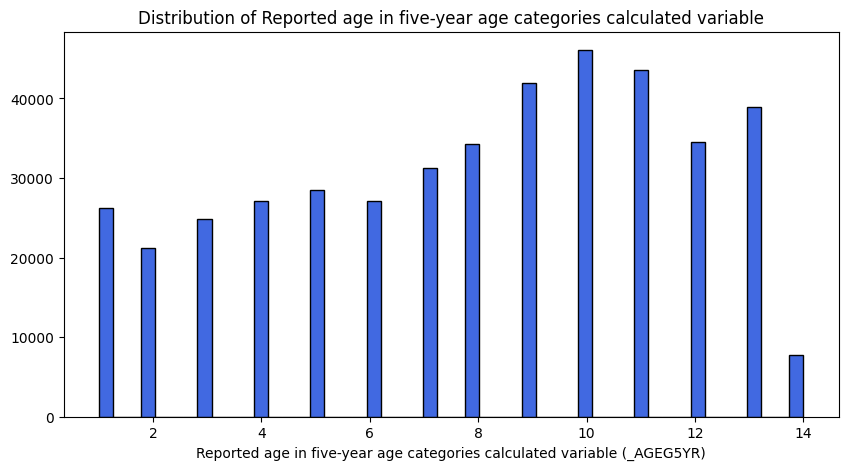

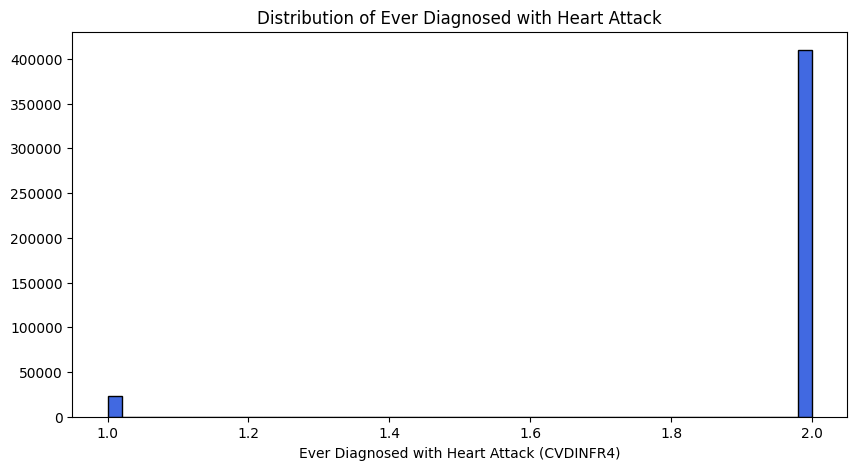

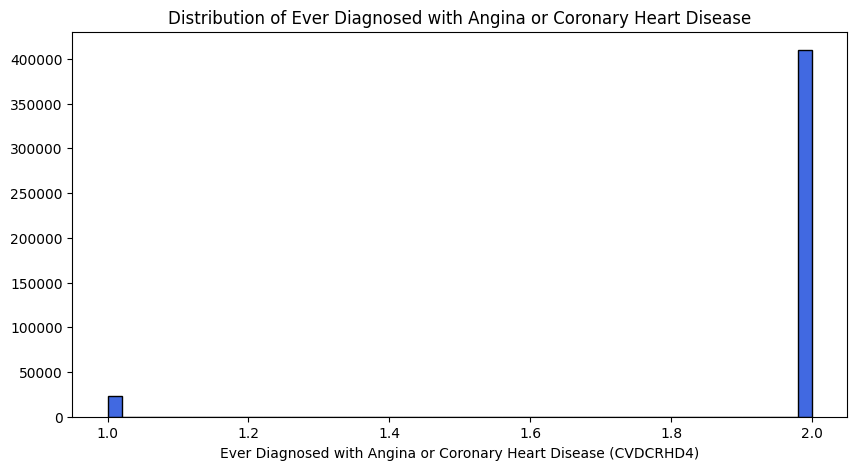

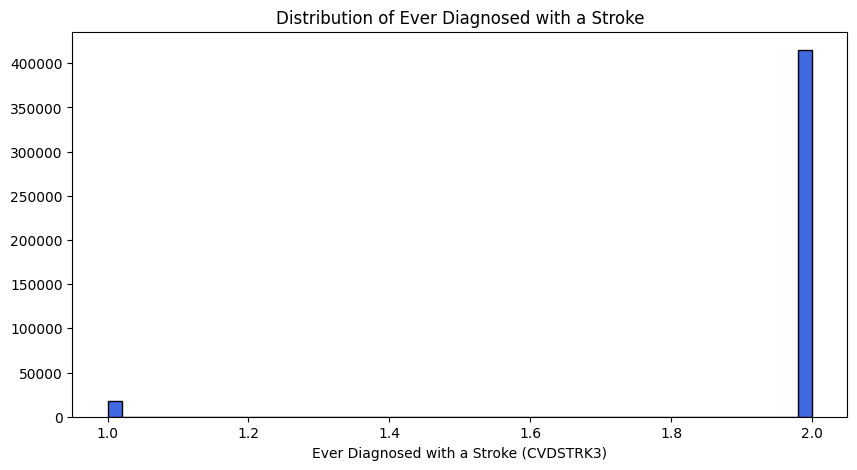

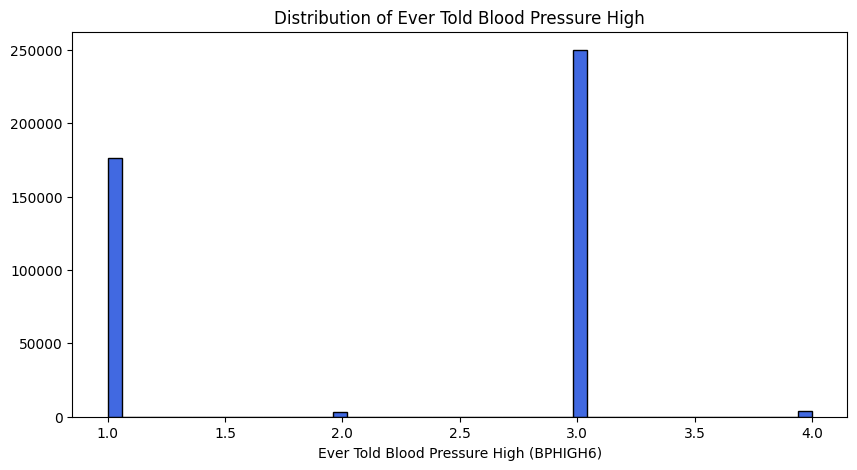

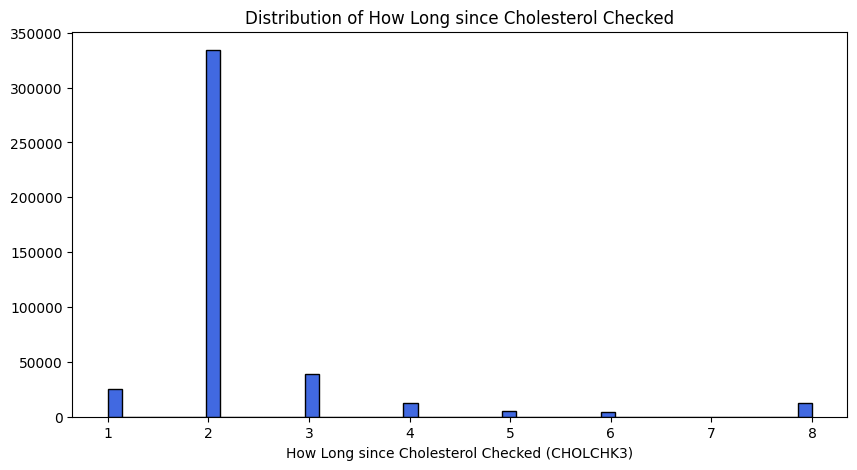

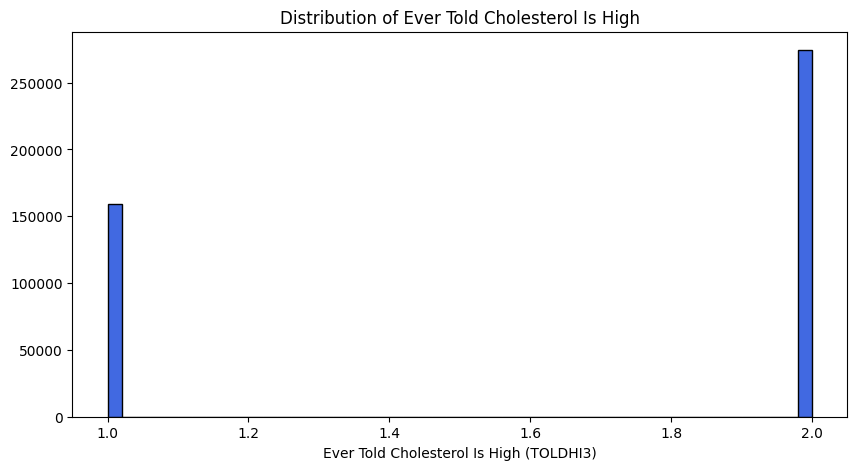

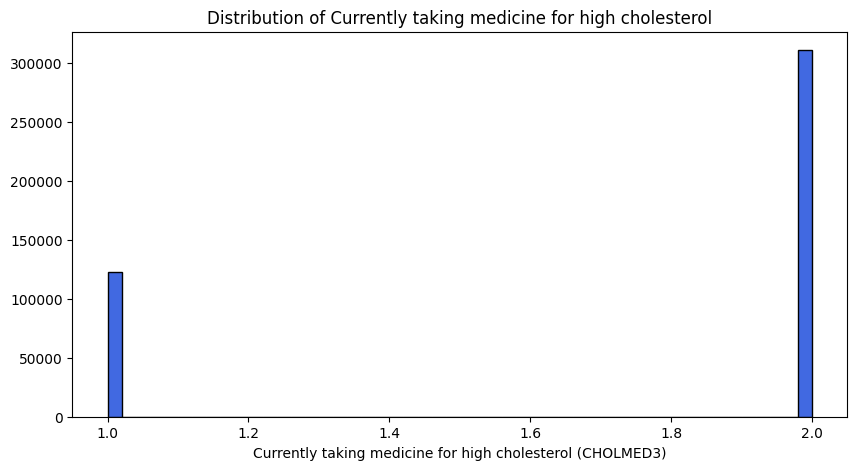

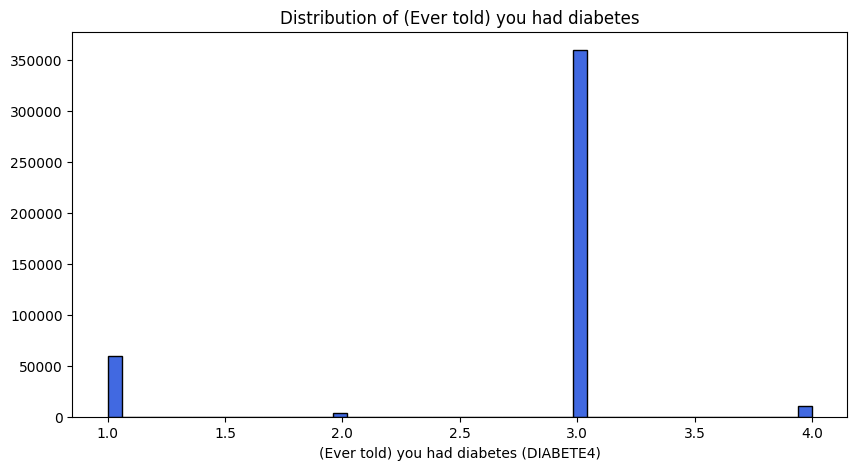

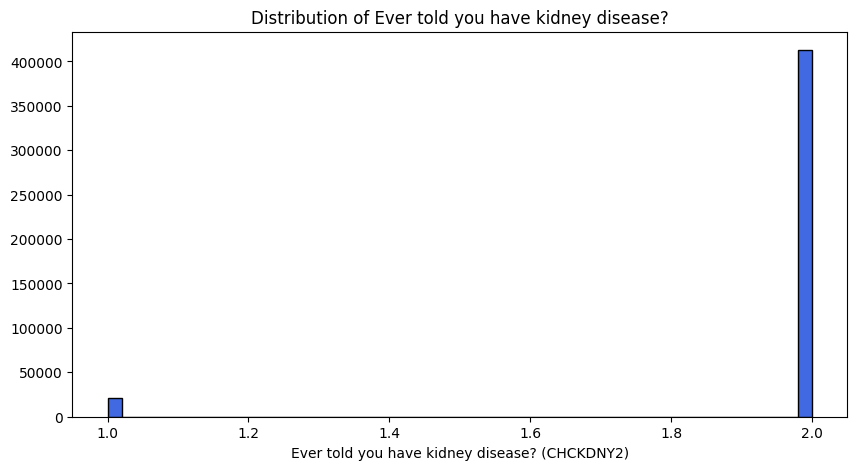

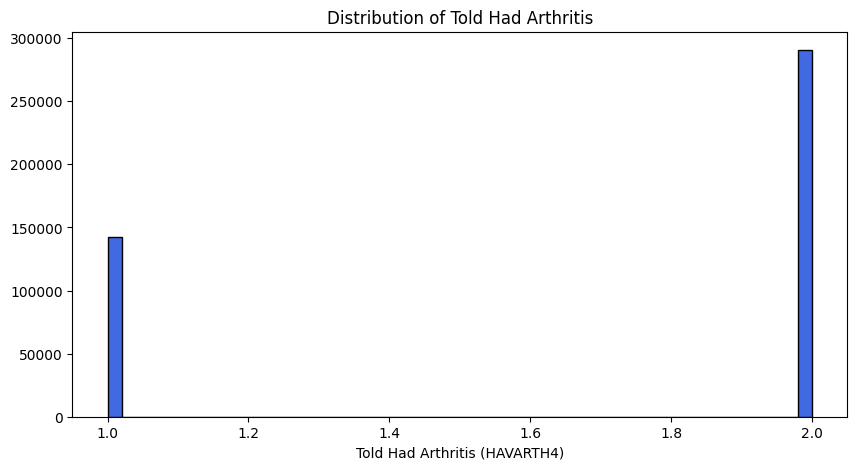

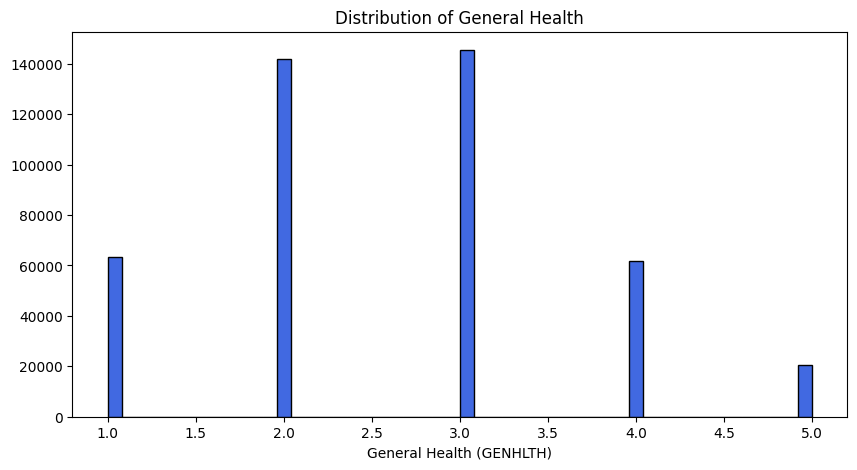

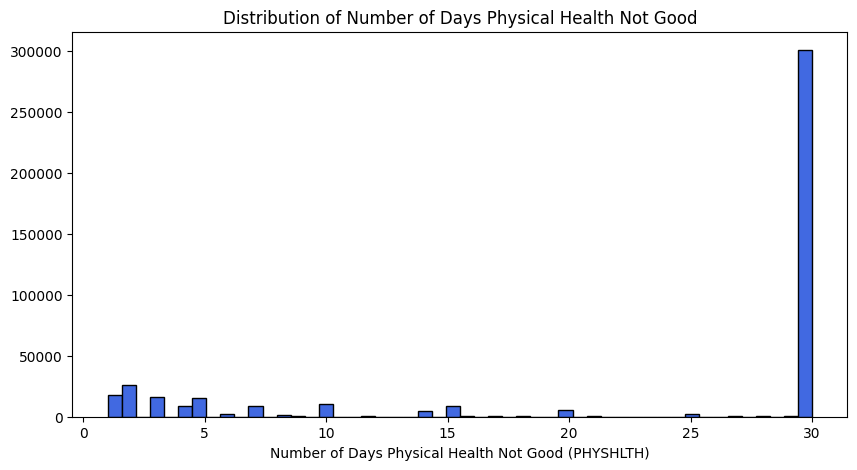

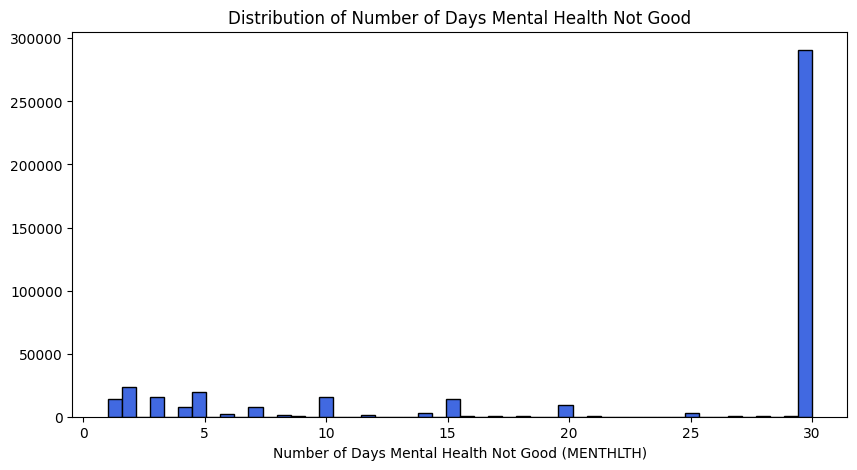

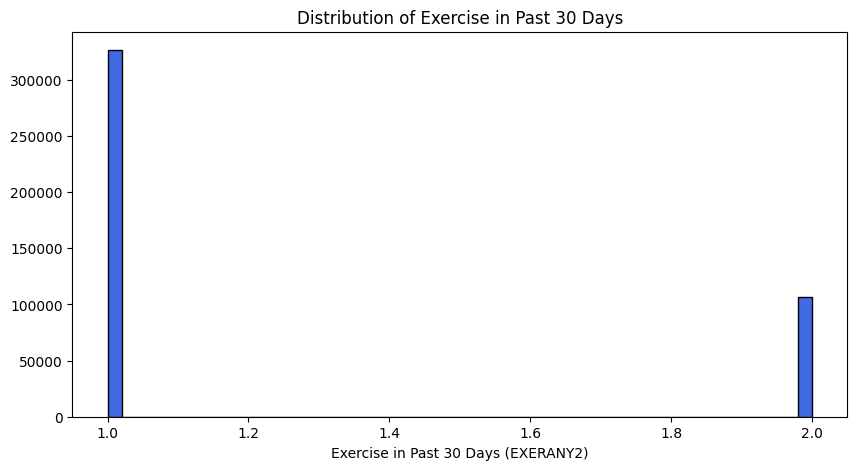

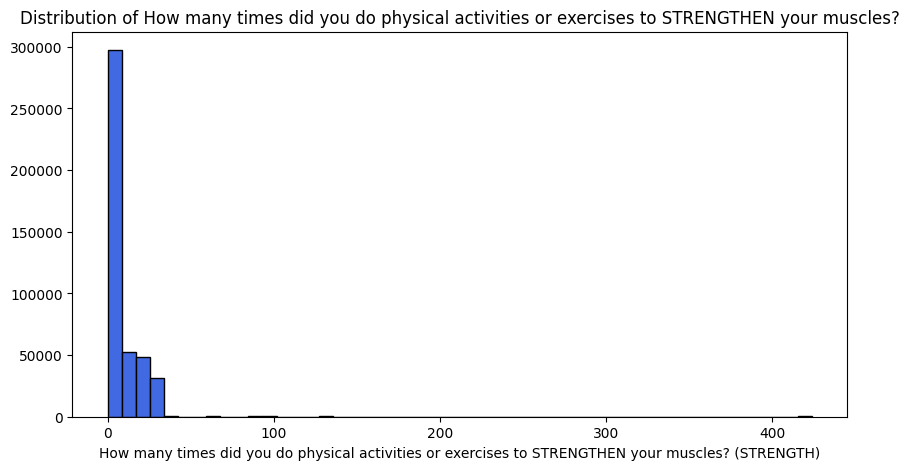

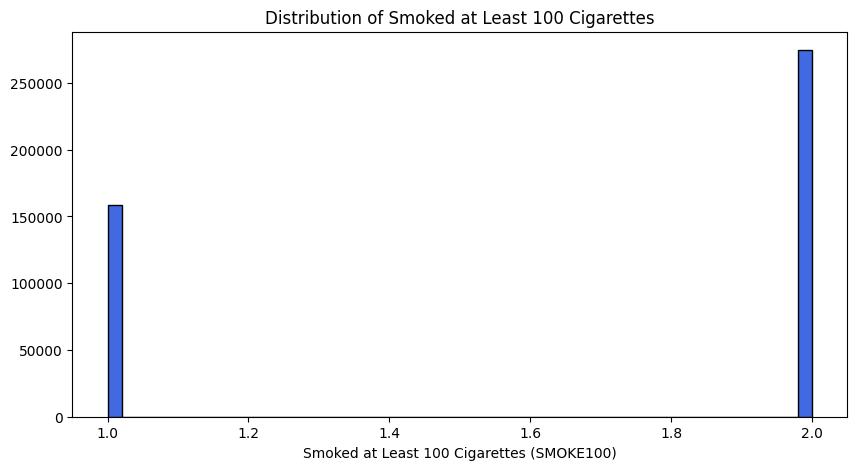

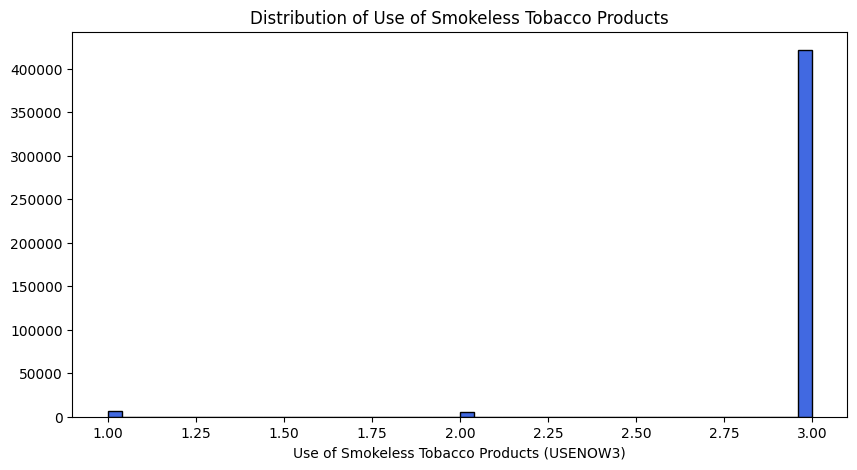

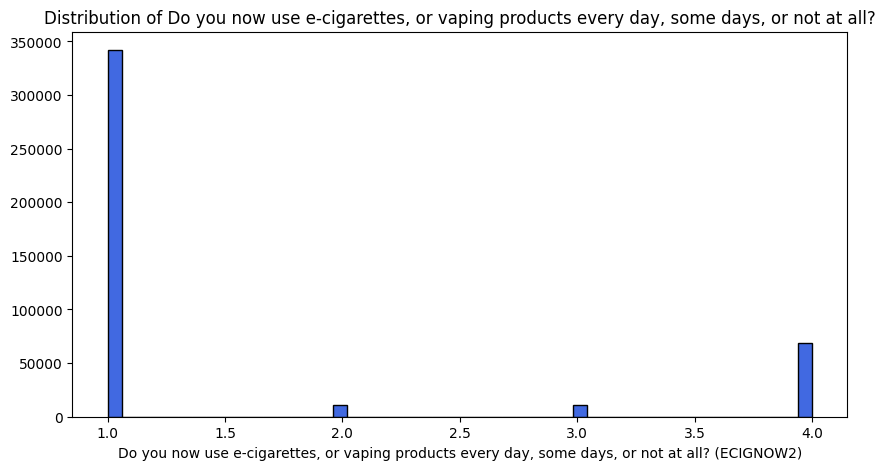

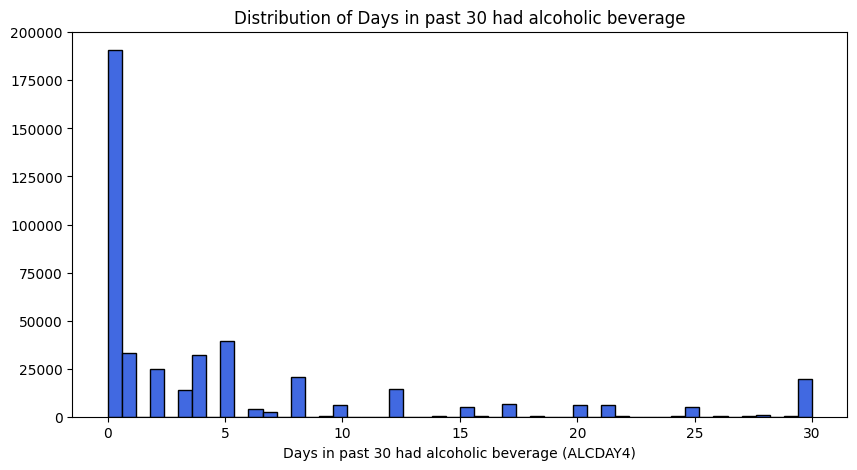

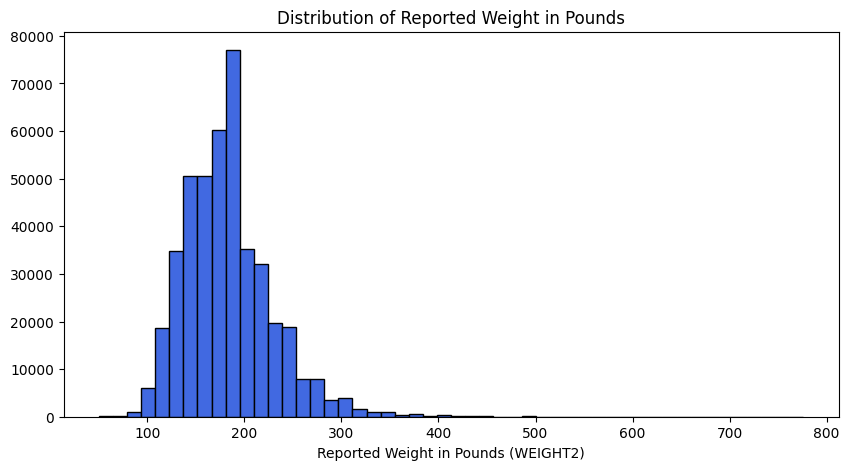

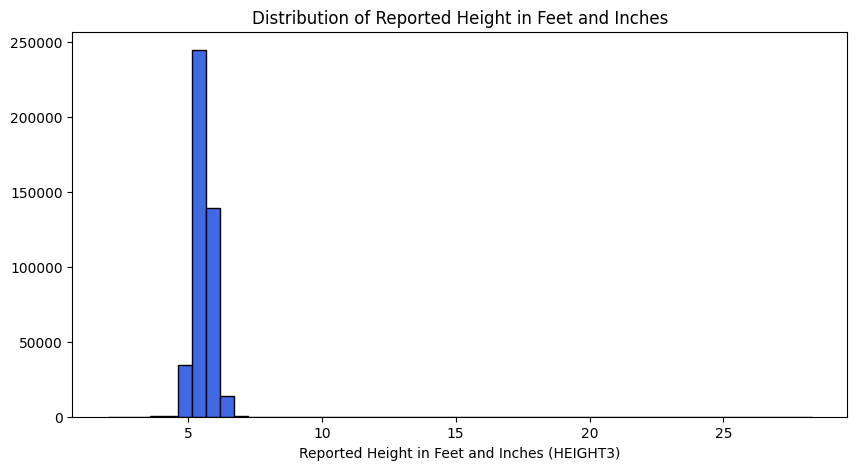

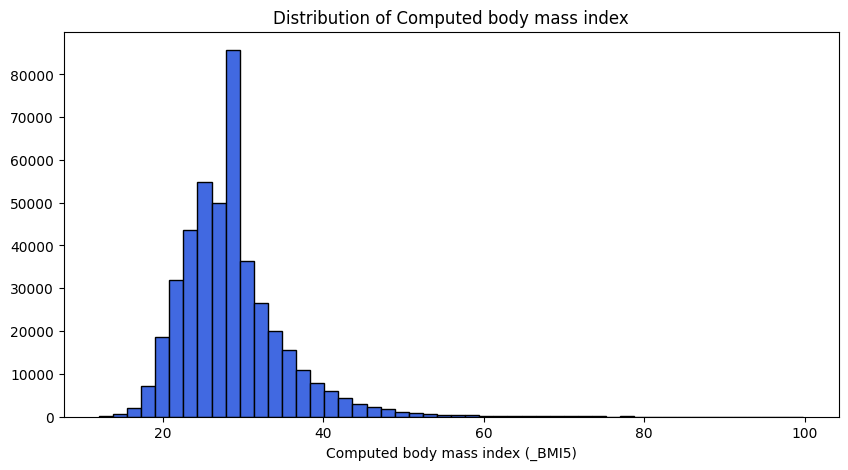

In [43]:
for col in selected_features:
    plt.figure(figsize=(10,5))
    plt.hist(df_filtered[col], bins = 50, color='royalblue', edgecolor='black')
    plt.xlabel(f"{sas_variable[col]} ({col})")
    plt.title(f"Distribution of {sas_variable[col]}")
    plt.show()
